## Calculation of Inital Movement Vectors 

In [103]:
import seaborn as sns 
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import math

In [104]:
def cart2pol(x, y):
    r = []
    theta = []
    for i in range(len(x)): 
        r.append(np.sqrt((x[i])**2 + (y[i])**2))
        theta.append(np.arctan2(y[i], x[i]))
    return(r, theta)

In [105]:
movement_dfs = []
trial_dfs = []
n_backward_reaches = {}

num_participants = 20

# load in all participants movement and trial data
for i in range(num_participants):
     if i in [5, 11, 18]:
        continue 
     movement_df = pd.read_csv(f'../data/data_movements_{i}.csv')
     # count and filter out negative reaches
     backward_reaches = movement_df.loc[(movement_df.state == 'reach') & (movement_df.y < 0)].drop_duplicates('trial')
     n_backward_reaches[i] = len(backward_reaches)
     # movement_df = movement_df.loc[~movement_df.trial.isin(backward_reaches.trial)].copy() # ~ means 'not'
     movement_dfs.append(movement_df)
     trial_dfs.append(pd.read_csv(f'../data/data_trials_{i}.csv'))

for df in trial_dfs:
    df['trial'] = df.trial - 1

In [106]:
n_backward_reaches

{0: 4,
 1: 2,
 2: 9,
 3: 1,
 4: 2,
 6: 1,
 7: 3,
 8: 1,
 9: 6,
 10: 1,
 12: 4,
 13: 0,
 14: 0,
 15: 1,
 16: 3,
 17: 9,
 19: 0}

### Interpolate Data

In [107]:
def interpolate(df):
    
    df = df[['x', 'y', 'time', 'trial', 'state']]

    # Desired timestamp granularity
    timestamp_granularity = 0.001

    # Create an empty list to store interpolated dataframes
    interpolated_dfs = []

    # Iterate through the rows of the original DataFrame
    for i in range(len(df) - 1):
        # Extract data from the current and next rows
        current_row = df.iloc[i]
        next_row = df.iloc[i + 1]

        # Calculate the time points for interpolation
        t1 = current_row["time"]
        t2 = next_row["time"]

        # Calculate the number of points to interpolate between t1 and t2
        num_points = int((t2 - t1) / timestamp_granularity)

        # Create an array of interpolated time points
        interpolated_times = np.linspace(t1, t2, num_points + 1)

        # Perform linear interpolation for 'x' and 'y' columns
        interpolated_x = np.interp(interpolated_times, [t1, t2], [current_row["x"], next_row["x"]])
        interpolated_y = np.interp(interpolated_times, [t1, t2], [current_row["y"], next_row["y"]])

        # Create a new DataFrame for this segment of interpolation
        interpolated_segment = pd.DataFrame({
            "x": interpolated_x,
            "y": interpolated_y,
            "time": interpolated_times,
            "trial": [current_row["trial"]] * (num_points + 1),  # Include trial number
            "state": [current_row["state"]] * (num_points + 1)  # Include state
        })

        # Append the interpolated segment to the list
        interpolated_dfs.append(interpolated_segment)

    # Concatenate all interpolated segments into one DataFrame
    interpolated_df = pd.concat(interpolated_dfs, ignore_index=True)

    return interpolated_df

# interpolate all participants' movement data for a time granularity of 0.001s
interpolated_dfs = [interpolate(df) for df in movement_dfs]

<Axes: xlabel='x', ylabel='y'>

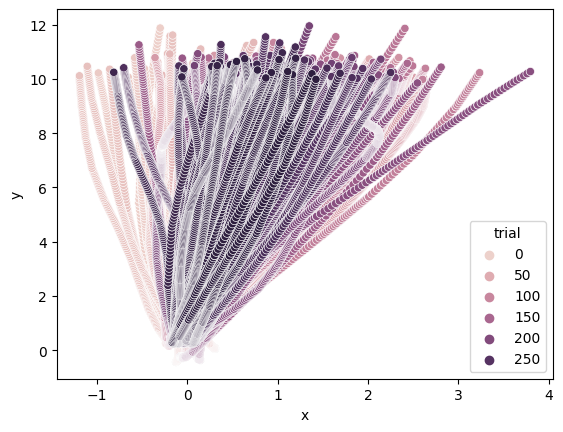

In [108]:
# plot first participant's interpolated movements data to see if it is ok
sns.scatterplot(data=interpolated_dfs[0].loc[interpolated_dfs[0].state == 'reach'], x = 'x', y = 'y', hue = 'trial')

### Calculate initial movmement vector and midpoint theta
Initial movement vector (IMV) is calculated by finding the point of peak velocity. The angular difference between the optimal movement vector and first point at which velocity exceeds 5% of peak velocity after a 2cm reach is considered the inital movement vector. 

Midpoint theta is defined and calculated as the first measured angle at 5cm (or higher until first measure is found). 

In [109]:
# velocity is the change in distance over the change in time

def get_change_dist(df):
    x1 = df['x'].values[:-1]
    x2 = df['x'].values[1:]
    y1 = df['y'].values[:-1]
    y2 = df['y'].values[1:]

    dist = np.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)

    # insert adds a 0 at the start because change in dist at the start is 0
    return np.insert(dist, 0, 0)

# add all change in dist into all the interpolated dfs and then calculate velocity for each
for df in interpolated_dfs:
    df['change_in_dist'] = get_change_dist(df)
    # velocity is the change in distance over the change in time
    df['velocity'] = df.change_in_dist / 0.001

In [110]:
# calculate onset velocities and join back to interpolated data
def get_onset(df): 
    onset_df = df.loc[df.state == 'reach'].groupby('trial').agg({'velocity': 'max'}).reset_index()
    onset_df = onset_df.rename(columns={'velocity': 'max_vel'})
    onset_df['onset_vel'] = onset_df.max_vel * 0.05 
    joined = pd.merge(df, onset_df, on='trial', how='left')
    return joined

interpolated_w_onset_dfs = [get_onset(df) for df in interpolated_dfs]

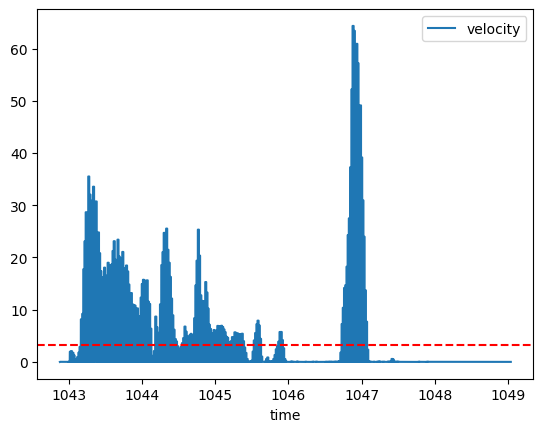

In [111]:
# plot velocity over time 
tmp = interpolated_w_onset_dfs[0].loc[interpolated_w_onset_dfs[0].trial == 150].copy()
tmp.plot(x='time', y='velocity')
plt.axhline(y=tmp.iloc[0].onset_vel, color='r', linestyle='--')

In [112]:
# initial movement vector is the angular difference between optimal vector (90deg) and the movement vector at movement onset (velocity exceeds 5% of peak)
def get_imv(df, thresh=2.0):
    imv_df = df.copy()
    r, theta = cart2pol(imv_df.x.values, imv_df.y.values)
    imv_df['r'] = r
    imv_df['theta'] = theta
    imv_df['theta'] = imv_df.theta.apply(math.degrees)
    imv_df = imv_df.loc[(imv_df.velocity > imv_df.onset_vel) & (imv_df.r >= thresh) & (imv_df.state == 'reach')].drop_duplicates('trial')
    imv_df['theta'] = abs(90 - imv_df.theta)
    return imv_df

# since optimal vector is at 90 degrees, angular difference is 90 - theta

imv_dfs = [get_imv(df) for df in interpolated_w_onset_dfs]
# calculate midpoint theta
mid_dfs = [get_imv(df, thresh=5.0) for df in interpolated_w_onset_dfs]

In [113]:
trial_df = pd.concat(trial_dfs, ignore_index=True).drop_duplicates('trial')

In [114]:
def add_prev_uncertainty(imv_df, trial):
    previous_uncertainty = ['no_uncertainty'] * 21

    for i in range(21, len(trial) - 99):
        prev_row = trial.iloc[i - 1]
        if prev_row.no_uncertainty == True:
            previous_uncertainty.append('no_uncertainty')
        elif prev_row.low_uncertainty == True: 
            previous_uncertainty.append('low_uncertainty')
        elif prev_row.high_uncertainty == True: 
            previous_uncertainty.append('high_uncertainty')
        elif prev_row.unlimited_uncertainty == True: 
            previous_uncertainty.append('unlimited_uncertainty')
        else: 
            previous_uncertainty.append('unlimited_uncertainty')

    imv_df_w_prev_uncertainty = pd.merge(imv_df, trial, on = 'trial', how = 'left')

    previous_uncertainty += ['unlimited_uncertainty'] * (300 - len(previous_uncertainty))
    imv_df_w_prev_uncertainty['previous_uncertainty'] = previous_uncertainty

    return imv_df_w_prev_uncertainty

imv_dfs_w_prev_uncertainty = []
for i in range(len(imv_dfs)):
    imv_dfs_w_prev_uncertainty.append(add_prev_uncertainty(imv_dfs[i], trial_dfs[i]))

In [115]:
# remove any backwards reaching trials

dfs_remove_backwards_reaches = []

for i in range(len(movement_dfs)):
    imv_df = imv_dfs_w_prev_uncertainty[i]
    movement_df = movement_dfs[i]
    backward_reaches = movement_df.loc[(movement_df.state == 'reach') & (movement_df.y < 0)].drop_duplicates('trial')
    dfs_remove_backwards_reaches.append(imv_df.loc[~imv_df.trial.isin(backward_reaches.trial)].copy())

In [116]:
combined_df = pd.concat(dfs_remove_backwards_reaches)[['trial', 'theta', 'r', 'previous_uncertainty']]
combined_df = pd.merge(
    combined_df.rename(columns={'theta': 'initial_theta'}),
    pd.concat(mid_dfs).rename(columns={'theta': 'midpoint_theta'})[['trial', 'midpoint_theta']],
    on='trial',
    how='left')

combined_df = combined_df.groupby('trial').agg({'initial_theta': 'mean', 'midpoint_theta': 'mean', 'previous_uncertainty': 'first'}).reset_index()

combined_df = pd.merge(combined_df, trial_df, on='trial', how='left')

In [117]:
combined_df

,trial,initial_theta,midpoint_theta,previous_uncertainty,Unnamed: 0,cursor_vis,midpoint_vis,endpoint_vis,cursor_sig,cursor_mp_sig,...,rot,cycle,target_angle,no_uncertainty,low_uncertainty,high_uncertainty,unlimited_uncertainty,endpoint_theta,movement_time,movement_initiation_time
0,0,3.865832,3.317002,no_uncertainty,0,1.0,1.0,0.0,0.0,0.0,...,0.0,0,90,0.0,0.0,0.0,0.0,85.529673,0.148947,0.435249
1,1,3.565855,2.039499,no_uncertainty,0,1.0,1.0,0.0,0.0,0.0,...,0.0,1,90,0.0,0.0,0.0,0.0,89.875889,0.134966,0.501257
2,2,2.823191,1.357669,no_uncertainty,0,1.0,1.0,0.0,0.0,0.0,...,0.0,2,90,0.0,0.0,0.0,0.0,89.687056,0.133889,0.499285
3,3,3.310478,2.001736,no_uncertainty,0,1.0,1.0,0.0,0.0,0.0,...,0.0,3,90,0.0,0.0,0.0,0.0,89.250628,0.482999,0.500211
4,4,3.684253,2.552622,no_uncertainty,0,1.0,1.0,0.0,0.0,0.0,...,0.0,4,90,0.0,0.0,0.0,0.0,91.459120,0.100967,0.483212
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,295,4.725210,3.296673,unlimited_uncertainty,0,0.0,0.0,0.0,0.0,0.0,...,0.0,295,90,0.0,0.0,0.0,0.0,83.477506,0.164723,0.368287
296,296,6.096379,4.625426,unlimited_uncertainty,0,0.0,0.0,0.0,0.0,0.0,...,0.0,296,90,0.0,0.0,0.0,0.0,83.836307,0.165814,0.267227
297,297,4.770765,4.537405,unlimited_uncertainty,0,0.0,0.0,0.0,0.0,0.0,...,0.0,297,90,0.0,0.0,0.0,0.0,87.079872,0.231859,0.451219
298,298,4.891953,4.670242,unlimited_uncertainty,0,0.0,0.0,0.0,0.0,0.0,...,0.0,298,90,0.0,0.0,0.0,0.0,82.303169,0.115765,0.484242


In [118]:
combined_df['midpoint_error'] = combined_df.midpoint_theta + combined_df.rot
regression_df = combined_df[['trial', 'initial_theta', 'previous_uncertainty', 'midpoint_error']].copy()

<Axes: xlabel='trial', ylabel='initial_theta'>

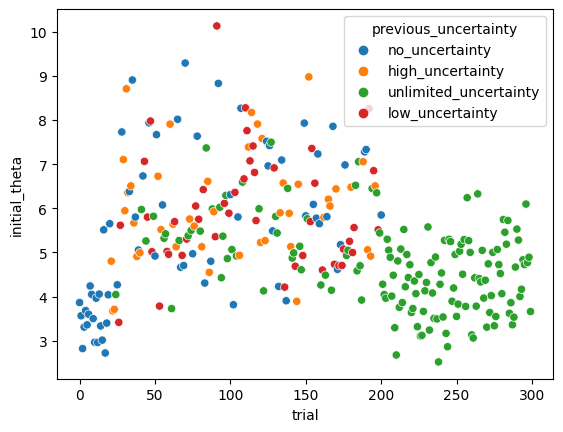

In [119]:
sns.scatterplot(data=combined_df, x='trial', y='initial_theta', hue='previous_uncertainty')

### Extract important data for regression analysis 

In [120]:
# save to csv
regression_df.to_csv('../data/regression_data.csv', index=False)

### Endpoint theta plot

In [121]:
# remove any backwards reaching trials

trial_dfs_no_back_reach = []

for i in range(len(movement_dfs)):
    trial_df = trial_dfs[i]
    movement_df = movement_dfs[i]
    backward_reaches = movement_df.loc[(movement_df.state == 'reach') & (movement_df.y < 0)].drop_duplicates('trial')
    trial_dfs_no_back_reach.append(trial_df.loc[~trial_df.trial.isin(backward_reaches.trial)].copy())

In [122]:
# endpoint theta as recorded during the experiment 

endpoint_theta_df = pd.concat(trial_dfs_no_back_reach)[['trial', 'no_uncertainty', 'low_uncertainty', 'high_uncertainty', 'unlimited_uncertainty', 'endpoint_theta']]
endpoint_theta_mean= endpoint_theta_df[['trial', 'endpoint_theta']].groupby('trial').agg('mean').reset_index()
endpoint_theta = pd.merge(endpoint_theta_mean, endpoint_theta_df.drop_duplicates('trial').drop('endpoint_theta', axis=1), on='trial', how='left')
endpoint_theta

,trial,endpoint_theta,no_uncertainty,low_uncertainty,high_uncertainty,unlimited_uncertainty
0,0,90.254412,0.0,0.0,0.0,0.0
1,1,90.313775,0.0,0.0,0.0,0.0
2,2,90.148380,0.0,0.0,0.0,0.0
3,3,89.750853,0.0,0.0,0.0,0.0
4,4,90.243432,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...
295,295,88.629006,0.0,0.0,0.0,0.0
296,296,89.538409,0.0,0.0,0.0,0.0
297,297,90.919627,0.0,0.0,0.0,0.0
298,298,89.885672,0.0,0.0,0.0,0.0


In [123]:
previous_uncertainty = ['baseline_no_uncertainty'] * 21

for i in range(21, 300):
    prev_row = endpoint_theta.iloc[i - 1]
    if prev_row.no_uncertainty == True:
        previous_uncertainty.append('no_uncertainty')
    elif prev_row.low_uncertainty == True: 
        previous_uncertainty.append('low_uncertainty')
    elif prev_row.high_uncertainty == True: 
        previous_uncertainty.append('high_uncertainty')
    elif prev_row.unlimited_uncertainty == True: 
        previous_uncertainty.append('unlimited_uncertainty')
    else: 
        previous_uncertainty.append('washout_unlimited_uncertainty')

endpoint_theta['previous_uncertainty'] = previous_uncertainty

In [124]:
# subtract theta from ideal angle reach of 90 degrees 
endpoint_theta['endpoint_theta'] = abs(90 - endpoint_theta.endpoint_theta)
endpoint_theta

,trial,endpoint_theta,no_uncertainty,low_uncertainty,high_uncertainty,unlimited_uncertainty,previous_uncertainty
0,0,0.254412,0.0,0.0,0.0,0.0,baseline_no_uncertainty
1,1,0.313775,0.0,0.0,0.0,0.0,baseline_no_uncertainty
2,2,0.148380,0.0,0.0,0.0,0.0,baseline_no_uncertainty
3,3,0.249147,0.0,0.0,0.0,0.0,baseline_no_uncertainty
4,4,0.243432,0.0,0.0,0.0,0.0,baseline_no_uncertainty
...,...,...,...,...,...,...,...
295,295,1.370994,0.0,0.0,0.0,0.0,washout_unlimited_uncertainty
296,296,0.461591,0.0,0.0,0.0,0.0,washout_unlimited_uncertainty
297,297,0.919627,0.0,0.0,0.0,0.0,washout_unlimited_uncertainty
298,298,0.114328,0.0,0.0,0.0,0.0,washout_unlimited_uncertainty


<Axes: xlabel='trial', ylabel='endpoint_theta'>

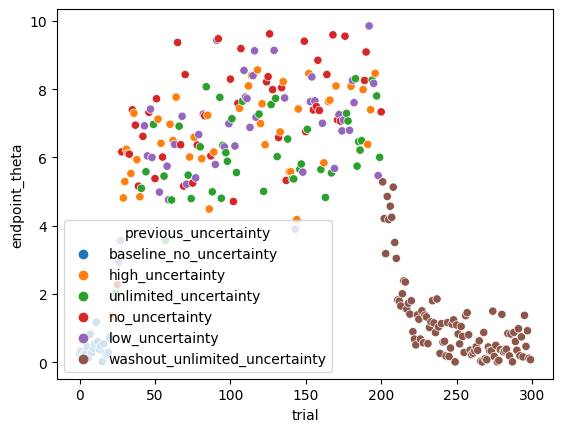

In [125]:
sns.scatterplot(data=endpoint_theta, x='trial', y='endpoint_theta', hue='previous_uncertainty')

In [126]:
endpoint_theta.to_csv('../data/endpoint_theta.csv')

In [127]:
# def get_emv(df):
#     emv_df = df.copy()
#     r, theta = cart2pol(emv_df.x.values, emv_df.y.values)
#     emv_df['r'] = r
#     emv_df['theta'] = theta
#     emv_df['theta'] = emv_df.theta.apply(math.degrees)
#     emv_df = emv_df.loc[(emv_df.r >= 10.0) & (emv_df.state == 'reach')].drop_duplicates('trial')
#     emv_df['theta'] = abs(90 - emv_df.theta)
#     return emv_df

# emv_dfs = [get_emv(df) for df in interpolated_w_onset_dfs]


In [128]:
# emv_dfs = pd.concat(emv_dfs)

In [129]:
# emv_dfs = emv_dfs[['trial','theta']].groupby('trial').agg({'theta': 'mean'})

In [130]:
# sns.scatterplot(data=emv_dfs, x='trial', y='theta')